In [20]:
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import itertools
import ast
from textblob import TextBlob

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium import plugins

import json
import requests
from urllib.parse import quote

### Collect data using Yelp API

In [2]:
# Set NEW_RUN to False to load previously queried and cleaned data from .csv in the directory, 
# set to True to re-query and process data using Yelp API.
NEW_RUN = False;
DATA_FILE = 'businesses_df.csv'

# Define Yelp API variables
API_KEY = 'EnterAPIKeyHere'
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'

SEARCH_LIMIT = 50 # Max is 50, use offset to get up to the max searchable 1000 results
DEFAULT_LOCATION = 'New York, NY'
DEFAULT_TERM = 'Restaurants'
CUISINE_TERMS = ['Chinese','Italian','Mexican','Thai','American','Japanese','Indian','Greek','French','Mediterranean',
                'Turkish','Spanish','Asian','Vietnamese','Korean','German','Peruvian','Moroccan','Caribbean','Ethiopian',
                'Fast food','Cuban','European','Middle Eastern', 'Cajun','Soul','Jewish','Iranian','Malaysian','Hawaiian',
                'Indonesian','Pakistani','Sri Lankan','Latin American'] # 34 cuisines

In [3]:
# API request
def request(host, path, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % API_KEY,
    }

    response = requests.request('GET', url, headers=headers, params=url_params)
    
    return response.json() # returns a dict

# Specific search-type API request
def search(term, location, offset_counter):
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT,
        'offset': offset_counter*50
    }
    return request(API_HOST, SEARCH_PATH, url_params=url_params)

# Specific review-type API request
def get_reviews(id):
    review_path = BUSINESS_PATH + id + '/reviews'
    return request(API_HOST, review_path, API_KEY)

In [4]:
# Submit search-type queries
if NEW_RUN == True:
    # Submit queries to get a list of businesses (up to 1000 for each cuisine)
    businesses_raw = []
    for cuisine in CUISINE_TERMS:
        for offset_counter in np.arange(0,20): # loop through different offsets to overcome 50 search limit to get 1000 results
            response = search(cuisine,'New York, NY', offset_counter) # TO DO: loop for different cuisines
            businesses_raw.append(response['businesses'])

    # create a raw list of businesses with potential duplicates
    businesses_raw = list(itertools.chain.from_iterable(businesses_raw)) # flatten list of list into a single list

    # Remove duplicate businesses
    businesses = []
    for i in range(0, len(businesses_raw)):
        if businesses_raw[i] not in businesses_raw[i+1:]:
            businesses.append(businesses_raw[i])

    # Convert to dataframe
    businesses_df = pd.DataFrame.from_dict(businesses)

    # businesses_df.to_csv(DATA_FILE, index=False) # Save

In [5]:
# Submit review-type queries
if NEW_RUN == True:
    businesses_df['reviews'] = businesses_df['id'].apply(get_reviews)
    # businesses_df.to_csv(DATA_FILE, index=False) # Save

### Clean the data

In [6]:
# Build columns for coordinates, zip code
if NEW_RUN == True:
    businesses_df['longitude'] = ""
    businesses_df['latitude'] = ""
    businesses_df['zip code'] = ""
    for i in np.arange(len(businesses_df)):
        businesses_df['longitude'].iloc[i] = ast.literal_eval(businesses_df['coordinates'][i])['longitude']
        businesses_df['latitude'].iloc[i] = ast.literal_eval(businesses_df['coordinates'][i])['latitude']
        businesses_df['zip code'].iloc[i] = ast.literal_eval(businesses_df['location'][i])['zip_code']
    # businesses_df.to_csv(DATA_FILE, index=False) # Save

In [7]:
# Build cuisine column (limited to one cuisine type only)
if NEW_RUN == True:
    businesses_df['cuisine'] = ""
    for cuisine in CUISINE_TERMS:
        for i in np.arange(len(businesses_df)):
            if cuisine in businesses_df['categories'].iloc[i]:
                businesses_df['cuisine'].iloc[i] = cuisine
    # businesses_df.to_csv(DATA_FILE, index=False) # Save

In [8]:
# Build sentiment score column from review texts using sentiment analysis
if NEW_RUN == True:
    businesses_df['review_sentiment'] =""
    for i in np.arange(len(businesses_df)):
        if len(ast.literal_eval(businesses_df['reviews'].iloc[i])['reviews']) == 3: #If there are 3 reviews excerpts for this restaurant
            txt1 = TextBlob(ast.literal_eval(businesses_df['reviews'].iloc[i])['reviews'][0]['text'])
            txt2 = TextBlob(ast.literal_eval(businesses_df['reviews'].iloc[i])['reviews'][1]['text'])
            txt3 = TextBlob(ast.literal_eval(businesses_df['reviews'].iloc[i])['reviews'][2]['text'])
            businesses_df['review_sentiment'].iloc[i] = 100 * np.mean([txt1.sentiment.polarity,txt2.sentiment.polarity,txt3.sentiment.polarity])
        else:
            businesses_df['review_sentiment'].iloc[i] = 0 # Fill with 0
    #businesses_df.to_csv(DATA_FILE, index=False) # Save

In [9]:
# If data was not newly collected, then load existing data from .csv in directory
if NEW_RUN == False:
    businesses_df = pd.read_csv(DATA_FILE)

In [10]:
# Drop rows with missing location data
businesses_df = businesses_df.dropna(subset=['longitude','latitude','zip code'])

# Convert zip code to int
businesses_df['zip code'] = businesses_df['zip code'].astype(int)

# Build borough column
zip_to_bor = pd.read_csv('zip_to_borough.csv')
borough_dict = dict(zip(zip_to_bor['zip code'], zip_to_bor['borough']))
businesses_df['borough'] = businesses_df['zip code'].map(borough_dict)

# Recode price as int
businesses_df['price_recoded'] = businesses_df['price'].map({'$':1, "$$":2, '$$$':3, '$$$$':4})

# businesses_df.to_csv(DATA_FILE, index=False) # Save

# Preview dataframe
businesses_df.head()

,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,...,transactions,url,reviews,longitude,latitude,zip code,borough,price_recoded,cuisine,review_sentiment
0,"[{'alias': 'szechuan', 'title': 'Szechuan'}]","{'latitude': 40.72911, 'longitude': -73.98858}",(917) 388-3866,2686.634147,szechuan-mountain-house-new-york-2,https://s3-media3.fl.yelpcdn.com/bphoto/Gz84ka...,False,"{'address1': '23 St Marks Pl', 'address2': '',...",Szechuan Mountain House,1.917388e+10,...,[],https://www.yelp.com/biz/szechuan-mountain-hou...,"{'reviews': [{'id': 'pRAun_sLunrMW-yOtBD3IQ', ...",-73.988580,40.729110,10003,Manhattan,2.0,NaN,27.559975
1,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.68029, 'longitude': -73.9455}",(718) 622-4720,4977.229592,wing-cheong-restaurant-brooklyn,https://s3-media2.fl.yelpcdn.com/bphoto/pJw7wO...,False,"{'address1': '1389 Fulton St', 'address2': '',...",Wing Cheong Restaurant,1.718622e+10,...,[],https://www.yelp.com/biz/wing-cheong-restauran...,"{'reviews': [{'id': 'H81u74obnt4Ivyw70trbNg', ...",-73.945500,40.680290,11216,Brooklyn,1.0,Chinese,11.541667
2,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.71275, 'longitude': -73.99508}",(212) 962-7032,813.295978,sun-hing-lung-co-new-york-3,https://s3-media3.fl.yelpcdn.com/bphoto/l07KZE...,False,"{'address1': '58 Henry St', 'address2': '', 'a...",Sun Hing Lung Co,1.212963e+10,...,[],https://www.yelp.com/biz/sun-hing-lung-co-new-...,"{'reviews': [{'id': 'HmpQc0jRCXxDX2HXLBZT3g', ...",-73.995080,40.712750,10002,Manhattan,1.0,Chinese,48.538095
3,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.6933441162109, 'longitude': -7...",(347) 889-7210,2295.699978,hardee-chinese-american-new-york,https://s3-media1.fl.yelpcdn.com/bphoto/jqLvIg...,False,"{'address1': '351 Myrtle Ave', 'address2': '',...",Hardee Chinese- American,1.347890e+10,...,[],https://www.yelp.com/biz/hardee-chinese-americ...,"{'reviews': [{'id': 'aBYwxFwxtY75_u8mt1dk4g', ...",-73.972229,40.693344,11205,Brooklyn,1.0,Chinese,33.555556
4,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 40.70327, 'longitude': -73.9216299}",(718) 418-2888,6126.208451,china-garden-brooklyn-5,https://s3-media1.fl.yelpcdn.com/bphoto/OmBlzS...,False,"{'address1': '133 Irving Ave', 'address2': Non...",China Garden,1.718418e+10,...,[],https://www.yelp.com/biz/china-garden-brooklyn...,"{'reviews': [{'id': 'W0DjkMsCKzlrLBY_PgfbAg', ...",-73.921630,40.703270,11237,Brooklyn,1.0,Chinese,18.035354


### Geographical distribution of Manhattan restaurants

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


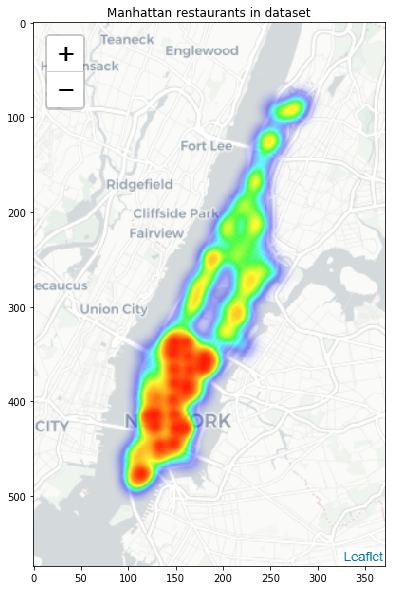

In [33]:
# Create a dataframe for Manhattan restaurants
mh_df = businesses_df[businesses_df['borough']=='Manhattan']
mh_df.shape

# Manually detected businesses with mislabelled Manhattan locations (coordinates don't match borough)
mislabelled_businesses = ['cappones-salumeria-new-york-3', 'yaki-taco-new-york-4', 'mausam-curry-n-bites-midtown',
                        'l-atelier-gourmand-manhattan', 'korilla-bbq-new-york-3', 'fuji-east-new-york', 
                        'sunrise-grill-jamaican-truck-new-york', 'slope-cafe-new-york', 'delroys-cafe-brooklyn-2',
                        'europan-café-new-york-4', 'oconomi-long-island-city-2', 'chickncone-new-york-4']

# Drop mislabelled Manhattan businesses
mh_df = mh_df[~mh_df['id'].isin(mislabelled_businesses)]


# Generate a map of restaurants in Manhattan
NYC_COORD = [40.785633, -73.967177]
mh_map = folium.Map(location=NYC_COORD, zoom_start=11, 
tiles='cartodbpositron', width=300, height=460)

# Heatmap of manhattan restaurants
coord_arr = mh_df[['latitude', 'longitude']].as_matrix() # Make array for heatmap
coord_tuples = [tuple(x) for x in coord_arr]
mh_map.add_children(plugins.HeatMap(coord_tuples, radius=10))

# Visualize distribution of Manhattan restaurants in the dataset
mh_map

mh_heatmap = plt.imread('mh_heatmap.png');
plt.figure(figsize=(10,10))
plt.imshow(mh_heatmap);
plt.title('Manhattan restaurants in dataset');

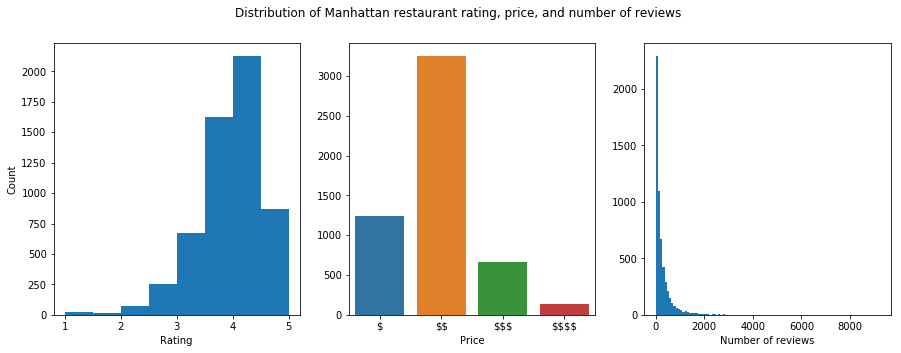

In [12]:
# Distribution of restaurant rating, price, and number of reviews
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of Manhattan restaurant rating, price, and number of reviews')

ax1 = plt.subplot(1,3,1)
plt.hist([mh_df['rating']],bins=8)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

ax2 = plt.subplot(1,3,2)
sns.countplot(data=mh_df,x='price_recoded')
ax2.set_xlabel('Price')
ax2.set_ylabel('')
ax2.set_xticklabels([r"\$",r"\$"r"\$",r"\$"r"\$"r"\$",r"\$"r"\$"r"\$"r"\$"])

ax3 = plt.subplot(1,3,3)
plt.hist([mh_df['review_count']],bins=100);
ax3.set_xlabel('Number of reviews');

### Most reviewed restaurants

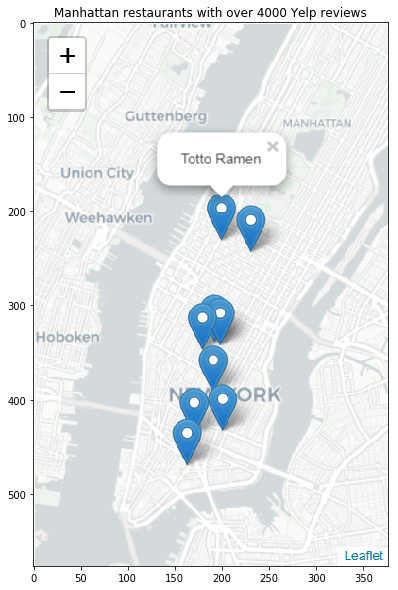

In [34]:
# Visualize Manhattan restaurants with the most number of reviews (>4000)
high_rev_map = folium.Map(location=NYC_COORD, zoom_start=11, 
tiles='cartodbpositron', width=300, height=460)
mh_df[mh_df['review_count']>4000].apply(lambda row: folium.Marker(location=[row['latitude'], row['longitude']], popup = folium.Popup(row['name'], parse_html=True)).add_to(high_rev_map), axis=1)
high_rev_map

mh_most_reviewed = plt.imread('mh_most_reviewed.png');
plt.figure(figsize=(10,10))
plt.imshow(mh_most_reviewed);
plt.title('Manhattan restaurants with over 4000 Yelp reviews');

### Map of highly and lowly rated restaurants

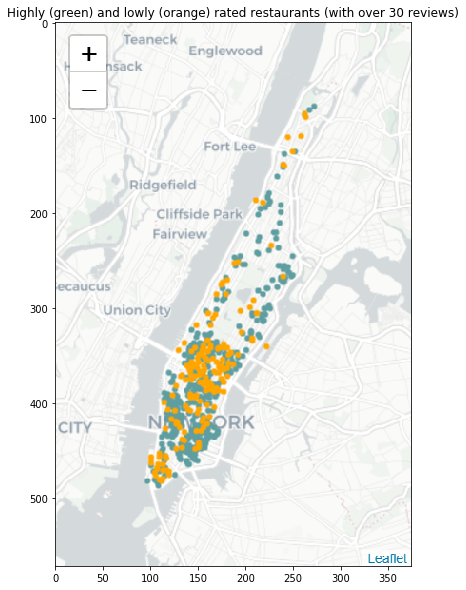

In [35]:
# Visualize Manhattan restaurants (above a certain # of reviews) with high and low ratings
min_rev = 30
rating_map = folium.Map(location=NYC_COORD, zoom_start=11, 
tiles='cartodbpositron', width=300, height=460)

#rated 4.5 or higher
mh_df[(mh_df['rating']>=4.5) & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'cadetblue',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(rating_map), axis=1)

#rated 2.5 or lower
mh_df[(mh_df['rating']<=2.5) & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'orange',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(rating_map), axis=1)

rating_map

mh_ratings = plt.imread('mh_ratings.png');
plt.figure(figsize=(10,10))
plt.imshow(mh_ratings);
plt.title('Highly (green) and lowly (orange) rated restaurants (with over 30 reviews)');

Restaurants with lower ratings appear to cluster around Times Square and Financial District.

### Map of the priciest restaurants

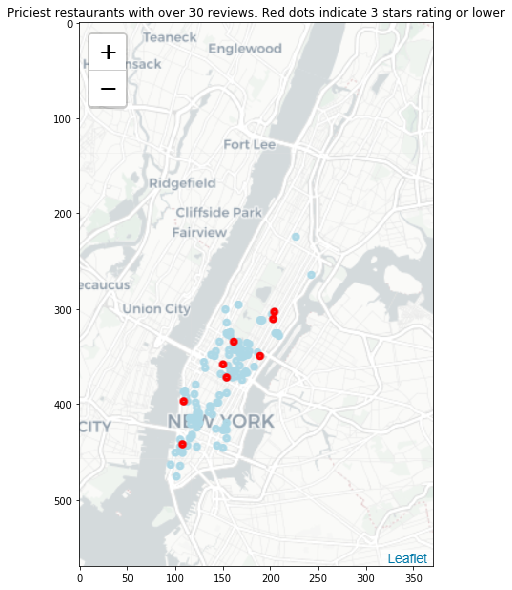

In [39]:
# Visualize Manhattan restaurants with high and low prices
price_map = folium.Map(location=NYC_COORD, zoom_start=11, 
tiles='cartodbpositron', width=300, height=460)

mh_df[(mh_df['price_recoded']==4) & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'lightblue',
    radius = 2, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(price_map), axis=1)

mh_df[(mh_df['price_recoded']==4) & (mh_df['review_count']>=min_rev) & (mh_df['rating']<=3)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'red',
    radius = 2, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(price_map), axis=1)

price_map

mh_ratings = plt.imread('mh_pricey.png');
plt.figure(figsize=(10,10))
plt.imshow(mh_ratings);
plt.title('Priciest restaurants with over 30 reviews. Red dots indicate 3 stars rating or lower');

### Map of four types of Asian cuisine restaurants

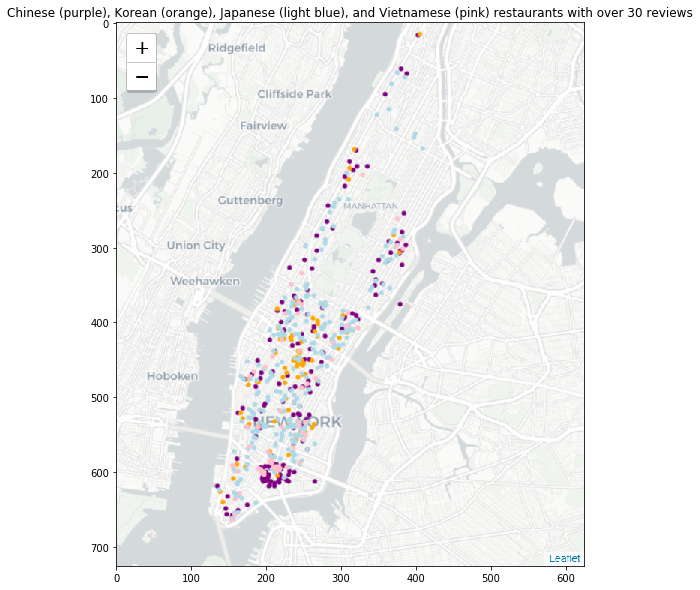

In [40]:
# Visualize Manhattan asian restaurants
asian_cuisine_map = folium.Map(location=[40.765633, -73.967177], zoom_start=11.5, 
tiles='cartodbpositron', width=500, height=580)

mh_df[(mh_df['cuisine']=='Chinese') & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'purple',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(asian_cuisine_map), axis=1)

mh_df[(mh_df['cuisine']=='Korean') & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'orange',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(asian_cuisine_map), axis=1)

mh_df[(mh_df['cuisine']=='Japanese') & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'lightblue',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(asian_cuisine_map), axis=1)

mh_df[(mh_df['cuisine']=='Vietnamese') & (mh_df['review_count']>=min_rev)].apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']], fill = True, color = 'pink',
    radius = 1, 
    popup = folium.Popup(row['name'], parse_html=True)).add_to(asian_cuisine_map), axis=1)

asian_cuisine_map

mh_asian_cuisines = plt.imread('mh_asian_cuisines.png');
plt.figure(figsize=(10,10))
plt.imshow(mh_asian_cuisines);
plt.title('Chinese (purple), Korean (orange), Japanese (light blue), and Vietnamese (pink) restaurants with over 30 reviews');

There are relatively few Vietnamese restaurants in upper Manhattan.

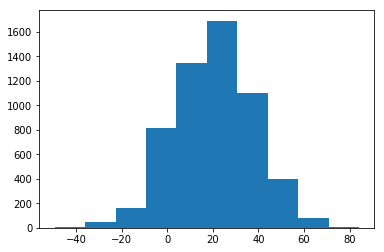

In [17]:
# Distribution of review sentiment scores
plt.hist(mh_df['review_sentiment']);

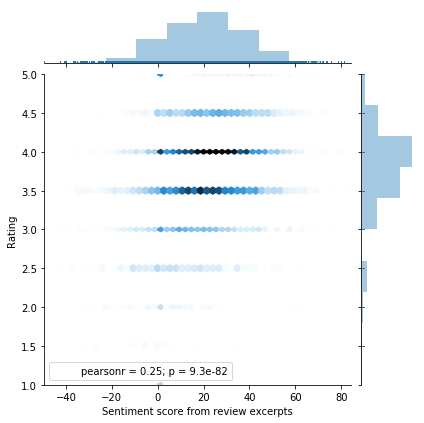

In [18]:
# Relationship between sentiment score and actual rating
g = sns.jointplot(data=mh_df, x='review_sentiment', y='rating', kind='hex', marginal_kws=dict(bins=10, rug=True))
g.ax_joint.get_legend()._set_loc(3)
g.set_axis_labels('Sentiment score from review excerpts','Rating');

Sentiment scores of restaurant review excerpts weakly correlates with restaurant rating. A stronger correlation might be possible with full reviews beyond those provided by the Yelp API.